In [1]:
import datetime
import json
import os
from collections import defaultdict
import gc
from joblib import dump, load
import random
import time
from typing import List, Tuple

from albumentations import (
    Compose, Flip, Rotate
)

import cv2
import dask
import dask.array as da

from google.cloud import storage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, precision_recall_curve

import tensorflow as tf
from tensorflow.keras.applications import inception_v3, resnet_v2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import Accuracy

from data_engineering.dask_image_stats_collector import stats_for_numpy_images 
from data_science.graph_utils import graph_model_history
from data_science.keras.model_checkpoint_gcs import ModelCheckpointGCS
from data_science.keras.cnn_models import basic_cnn_model, basic_cnn_model_with_regularization, pretrained_model
from data_science.serialization_utils import numpy_to_json, sklearn_precision_recall_curve_to_dict
from data_science.sklearn_batch_generator import SklearnBatchGenerator
from data_science.train import get_model_and_metadata_from_gcs, train_keras_model

In [2]:
print(tf.test.gpu_device_name())
print(tf.test.is_built_with_gpu_support())
print(tf.test.is_built_with_cuda())


True
True


In [3]:
root = '/home/jovyan/work/data/big_earth'
os.listdir(root)

['BigEarthNet-v1.0',
 'google_automl_cloud_and_shadow_dataset_small_augmented_test.csv',
 '.DS_Store',
 'google_automl_cloud_and_shadow_dataset_small.csv',
 'cloud_and_shadow_stats.csv',
 'npy_files',
 'patches_with_cloud_and_shadow.csv',
 'patches_with_seasonal_snow.csv',
 'BigEarthNet-v1.0.tar.gz',
 'model',
 'png_image_files_augmented',
 'google_automl_cloud_and_shadow_dataset_small_augmented.csv',
 'google_automl_cloud_and_shadow_dataset.csv',
 'metadata',
 'png_image_files',
 'npy_image_files']

In [60]:
random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/app/.gcs/big-earth-252219-fb2e5c109f78.json'
gcs_client = storage.Client()
bucket = gcs_client.bucket("big_earth")

n_classes = 1
n_epochs = 100
batch_size = 128

early_stopping_patience = 6
use_small_dataset = False
use_random_small_dataset = False

project_name = "cloud_and_shadow"
model_dir = os.path.join(root, "model/models")
log_dir = os.path.join(root, "model/logs")

gcs_hyperparameter_opt_record_dir = "model/hyperparameter_opt_record"
hyperparameter_opt_record_dir = os.path.join(root, gcs_hyperparameter_opt_record_dir)
# blob prefix
gcs_model_dir = "model/models"
# tensorboard
gcs_log_dir = "gs://big_earth/model/logs"


for directory in [log_dir, model_dir, hyperparameter_opt_record_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

In [6]:
# np.array(json.loads(df['binarized_labels'].iloc[0])).shape

def prepare_data(df):
    df['has_cloud_and_shadow_target'] = df['has_cloud_and_shadow_target'].apply(lambda x: np.array(json.loads(x)))
    df['binarized_labels'] = df['binarized_labels'].apply(lambda x: np.array(json.loads(x)))    
    df['image_path'] = root + "/npy_image_files/" + df['image_prefix'] + ".npy"
    return df

df = pd.read_csv(root + "/metadata/metadata.csv")
df = prepare_data(df)
print(df['binarized_labels'].iloc[0].shape)
print(df['has_cloud_and_shadow_target'].iloc[0].shape)
df = df.set_index('image_prefix', drop=False)

google_automl_dataset = pd.read_csv( '/app/data_science/google_automl_cloud_and_shadow_dataset_small.csv')
google_automl_dataset['image_prefix'] = google_automl_dataset['gcs_uri'].str.split('/').apply(lambda x: x[-1].replace(".png", ""))
google_automl_dataset = google_automl_dataset.set_index('image_prefix', drop=False)

train = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'TRAIN'].index]
valid = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'VALIDATION'].index]
test = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'TEST'].index]

print(len(train), len(valid), len(test))
print(len(train) + len(valid) + len(test) == len(google_automl_dataset))

(1, 44)
(1,)
1907 253 240
True


In [7]:
if os.path.exists(root + '/cloud_and_shadow_stats.csv'):
    all_stats = pd.read_csv(root + '/cloud_and_shadow_stats.csv')
else:
    stat_list = []
    npy_image_dir = root + "/npy_image_files"
    npy_files = [npy_image_dir + "/" + file + ".npy" for file in train['image_prefix'].values]
    start = time.time()
    stats = stats_for_numpy_images(npy_files,  use_test_data=False)
    stats['data'] = 'all'
    stat_list.append(stats)
    
    # get stats per class
    no_cloud = train[train['has_cloud_and_shadow'] == 0]
    cloud = train[train['has_cloud_and_shadow'] == 1]
    print(len(no_cloud), len(cloud))

    for name, data in [('no_cloud', no_cloud), ('cloud', cloud)]:
        npy_files = [npy_image_dir + "/" + file + ".npy" for file in data['image_prefix'].values]
        stats = stats_for_numpy_images(npy_files,  use_test_data=False)
        stats['data'] = name
        stat_list.append(stats)    
    
    all_stats = pd.concat(stat_list)
    all_stats['band'] = all_stats.index
    all_stats = all_stats.reset_index()  
    all_stats = all_stats.drop('index', axis=1)    
    all_stats.to_csv(root + '/cloud_and_shadow_stats.csv', index=False)
        
    print(f'stats computed in {time.time() - start}')

band_stats = all_stats[all_stats['data'] == 'all']    

In [8]:
x_train = train['image_path'].values
x_valid = valid['image_path'].values
x_test = test['image_path'].values

target = 'has_cloud_and_shadow_target'
y_train = np.stack(train[target].values)
y_valid = np.stack(valid[target].values)
y_test = np.stack(test[target].values)

print(y_train.shape, y_train[0].shape)

if use_small_dataset:
    size = batch_size
    n_epochs = 3
    x_train = np.concatenate([x_train[:size], x_train[-size:]])
    x_valid = np.concatenate([x_valid[:size], x_valid[-size:]])
    x_test = np.concatenate([x_test[:size], x_test[-size:]])

    y_train = np.concatenate([y_train[:size], y_train[-size:]])
    y_valid = np.concatenate([y_valid[:size], y_valid[-size:]])
    y_test = np.concatenate([y_test[:size], y_test[-size:]])
elif use_random_small_dataset:
    shape = (100, 1)
    x_train = np.concatenate([np.ones(shape), np.zeros(shape)])
    y_train = np.concatenate([np.ones(shape), np.zeros(shape)])

    x_valid = np.concatenate([np.ones(shape), np.zeros(shape)])
    y_valid = np.concatenate([np.ones(shape), np.zeros(shape)])

    y_train = np.random.randint(0, 2, (len(train), 44))
    y_valid = np.random.randint(0, 2, (len(valid), 44))
    y_test = np.random.randint(0, 2, (len(test), 44))
    y_test_labels = test['labels'].values

print(y_train.shape, y_train[0].shape)

(1907, 1) (1,)
(1907, 1) (1,)


len(train): 10
Epoch 1/2
1/1 [==============================] - 21s 21s/step - loss: 0.6983 - accuracy: 0.8000
Epoch 2/2
1/1 [==============================] - 27s 27s/step - loss: 2.4259e-06 - accuracy: 1.0000


/app/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb946626518>]],
      dtype=object)

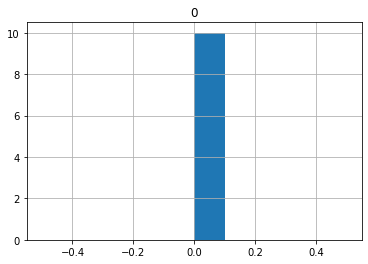

In [135]:
# Overfit on all training data
model = basic_cnn_model((120, 120, 3), n_classes)
experiment_name = f"{project_name}_basic_cnn_2020_1_31_test"

result = train_keras_model(
    random_seed=random_seed,
    x_train=x_train[:10], y_train=y_train[:10], x_valid=None, y_valid=None, image_augmentations=None, image_processor=None,
    band_stats=band_stats,
    bucket=bucket, model_dir=model_dir, gcs_model_dir=gcs_model_dir, gcs_log_dir=gcs_log_dir, 
    experiment_name=experiment_name, start_model=model, should_train_from_scratch=True, optimizer=Adam, lr=3e-4,
    should_upload_to_gcs=True,
    n_epochs=2, early_stopping_patience=10)
pd.DataFrame(result['y_pred_probs_train']).hist()

In [65]:
valid_generator = get_image_dataset(x=x_valid, y=y_valid, augmentations=None, image_processor=None,
                                    band_stats=band_stats, batch_size=batch_size)
actual_y_valid, pred_y_valid, pred_y_valid_probs = get_predictions_for_dataset(valid_generator, model) 
print('val_loss', binary_crossentropy(actual_y_valid, pred_y_valid_probs).numpy())
print('val_accuracy', accuracy_score(actual_y_valid, pred_y_valid))

val_loss 7.061103
val_accuracy 0.541501976284585


In [66]:
# Start basic_cnn_model_with_regularization by adding batch normalization and validation set 
model = basic_cnn_model_with_regularization((120, 120, 3), n_classes)
experiment_name = f"{project_name}_basic_cnn_with_regularization_2020_1_31"
result = train_keras_model(
    random_seed=random_seed,
    x_train=x_train, y_train=y_train, x_valid=None, y_valid=None, image_augmentations=None, image_processor=None,
    band_stats=band_stats,
    bucket=bucket, model_dir=model_dir, gcs_model_dir=gcs_model_dir, gcs_log_dir=gcs_log_dir, 
    experiment_name=experiment_name, start_model=model, should_train_from_scratch=False, optimizer=Adam, lr=3e-4,
    should_upload_to_gcs=True,
    n_epochs=200, early_stopping_patience=30)
pd.DataFrame(result['y_pred_probs']).hist()

KeyboardInterrupt: 

In [ ]:
graph_model_history(history.history)

In [11]:
augmentations_train = Compose([
    Flip(p=0.5),
    Rotate(limit=(0, 360), p=0.5),
])

In [15]:
# Add image augmentation
model = basic_cnn_model_with_regularization((120, 120, 3), n_classes)
experiment_name = f"{project_name}_basic_cnn_with_regularization_and_aug_2020_1_31"

result = train_keras_model(
    random_seed=random_seed,
    x_train=x_train, y_train=y_train, x_valid=None, y_valid=None, image_augmentations=augmentations_train, 
    image_processor=None,
    band_stats=band_stats,
    bucket=bucket, model_dir=model_dir, gcs_model_dir=gcs_model_dir, gcs_log_dir=gcs_log_dir, 
    experiment_name=experiment_name, start_model=model, should_train_from_scratch=False, optimizer=Adam, lr=3e-4,
    should_upload_to_gcs=True,
    n_epochs=100, early_stopping_patience=30)
pd.DataFrame(result['y_pred_probs_valid']).hist()

Resuming training at epoch 41
len(train): 1907
Epoch 42/100
      7/Unknown - 27s 4s/step - loss: 0.1788 - accuracy: 0.9342

KeyboardInterrupt: 

In [ ]:
graph_model_history(history.history)

In [24]:
import datetime
import json
import os
import time
from copy import copy

import sklearn
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import load_model

from data_science.keras.dataset import get_image_dataset, get_predictions_for_dataset
from data_science.keras.model_checkpoint_gcs import ModelCheckpointGCS
from data_science.serialization_utils import numpy_to_json, sklearn_precision_recall_curve_to_dict


def get_model_and_metadata_from_gcs(bucket, model_dir, model_file_ext, model_load_func, gcs_model_dir, experiment_name):
    model_and_metadata_filepath = os.path.join(model_dir, experiment_name)
    metadata_filepath = f"{model_and_metadata_filepath}_metadata.json"
    model_filepath = f"{model_and_metadata_filepath}.{model_file_ext}"

    gcs_model_and_metadata_filepath = os.path.join(gcs_model_dir, experiment_name)
    gcs_metadata_filepath = f"{gcs_model_and_metadata_filepath}_metadata.json"
    gcs_model_filepath = f"{gcs_model_and_metadata_filepath}.{model_file_ext}"

    gcs_metadata_blob = bucket.blob(gcs_metadata_filepath)
    gcs_model_blob = bucket.blob(gcs_model_filepath)

    if gcs_metadata_blob.exists():
        print('Downloading model blob.')
        gcs_metadata_blob.download_to_filename(metadata_filepath)

        with open(metadata_filepath, 'r') as json_file:
            model_metadata = json.load(json_file)

        model_metadata['epoch'] = int(model_metadata['epoch'])

        gcs_model_blob.download_to_filename(model_filepath)

        model = model_load_func(model_filepath)
        return model, model_metadata

    return None, None


def train_keras_model(*, random_seed, x_train, y_train, x_valid, y_valid, band_stats, image_augmentations,
                      image_processor, bucket, model_dir, gcs_model_dir, gcs_log_dir, should_upload_to_gcs,
                      experiment_name, model_name, start_model, should_train_from_scratch, optimizer, lr, batch_size=128,
                      n_epochs=100,
                      early_stopping_patience=6, metric_to_monitor='accuracy', should_return_serializable_metadata=False):
    # TODO - deserialize existing model metadata from json
    model, model_base_metadata = get_model_and_metadata_from_gcs(bucket, model_dir, "h5", load_model, gcs_model_dir,
                                                                 experiment_name)

    model_and_metadata_filepath = os.path.join(model_dir, experiment_name)
    gcs_model_and_metadata_filepath = os.path.join(gcs_model_dir, experiment_name)
    gcs_log_dir = os.path.join(gcs_log_dir, experiment_name)

    train_start_time = time.time()
    if model is None or should_train_from_scratch:
        now = datetime.datetime.utcnow().strftime("%Y-%m-%d %H:%M")
        model = start_model
        model_base_metadata = {
            'data': 'train_valid_google_automl_cloud_and_shadow_dataset_small.csv',
            'data_prep': 'normalization_augmentation',
            'experiment_name': experiment_name,
            'experiment_start_time': now,
            'model': model_name,
            'random_state': random_seed,
            # so that initial_epoch is 0
            'epoch_with_best_model': -1,
            'epochs_trained': -1,
            'optimizer': optimizer.__name__,
            'n_epochs': n_epochs,
            'early_stopping_patience': early_stopping_patience,
            'learning_rate': lr,
            'batch_size': batch_size
        }
    else:
        print('Resuming training at epoch', int(model_base_metadata['epochs_trained']) + 1)

    print(f'len(train): {len(x_train)}')

    if x_valid is not None:
        print(f'len(valid): {len(x_valid)}')
        metric_to_monitor = f'val_{metric_to_monitor}'
        valid_generator = get_image_dataset(x=x_valid, y=y_valid, augmentations=image_augmentations,
                                            image_processor=image_processor,
                                            band_stats=band_stats, batch_size=batch_size)
    else:
        valid_generator = None

    metrics = ['accuracy']
    loss = 'binary_crossentropy'

    optimizer = optimizer(learning_rate=lr)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    verbosity = 0
    train_generator = get_image_dataset(x=x_train, y=y_train, augmentations=image_augmentations,
                                        image_processor=image_processor,
                                        band_stats=band_stats, batch_size=batch_size)

    callbacks = [
        EarlyStopping(monitor=metric_to_monitor, patience=early_stopping_patience, verbose=verbosity),
        ReduceLROnPlateau(monitor=metric_to_monitor, factor=0.5, patience=early_stopping_patience, min_lr=1e-6),
        TensorBoard(gcs_log_dir, histogram_freq=1),
    ]

    if should_upload_to_gcs:
        callbacks.append(
            ModelCheckpointGCS(filepath=model_and_metadata_filepath, gcs_filepath=gcs_model_and_metadata_filepath,
                               gcs_bucket=bucket, model_metadata=model_base_metadata, monitor=metric_to_monitor,
                               verbose=verbosity))

    history = model.fit_generator(train_generator, initial_epoch=int(model_base_metadata['epochs_trained']) + 1,
                                  epochs=n_epochs,
                                  callbacks=callbacks,
                                  validation_data=valid_generator,
                                  shuffle=True, verbose=1)

    # load the best model
    if should_upload_to_gcs:
        best_model, best_model_metadata = get_model_and_metadata_from_gcs(bucket, model_dir, "h5", load_model,
                                                                          gcs_model_dir,
                                                                          experiment_name)
    else:
        best_model = model
        best_model_metadata = model_base_metadata

    y_actual_train, y_pred_train, y_pred_probs_train = get_predictions_for_dataset(train_generator, best_model)
    train_loss = binary_crossentropy(y_actual_train, y_pred_probs_train).numpy().tolist()

    # add more stats
    best_model_metadata.update({
        'history': history.history,
        'accuracy_train': sklearn.metrics.accuracy_score(y_actual_train, y_pred_train),
        'f1_score_train': sklearn.metrics.f1_score(y_actual_train, y_pred_train),
        'train_loss': train_loss,
        'loss': train_loss,
        'y_actual_train': y_actual_train,
        'y_pred_train': y_pred_train,
        'y_pred_probs_train': y_pred_probs_train,
        'epochs_trained': len(history.history),
        'elapsed_train_time': time.time() - train_start_time
    })

    if valid_generator is not None:
        y_actual_valid, y_pred_valid, y_pred_probs_valid = get_predictions_for_dataset(valid_generator, best_model)
        valid_loss = binary_crossentropy(y_actual_valid, y_pred_probs_valid).numpy().tolist()
        best_model_metadata.update({
            'accuracy_valid': sklearn.metrics.accuracy_score(y_actual_valid, y_pred_valid),
            'f1_score_valid': sklearn.metrics.f1_score(y_actual_valid, y_pred_valid),
            'confusion_matrix': sklearn.metrics.confusion_matrix(y_actual_valid, y_pred_valid),
            'precision_recall_curve': sklearn.metrics.precision_recall_curve(y_actual_valid, y_pred_valid),
            'y_actual_valid': y_actual_valid,
            'y_pred_valid': y_pred_valid,
            'y_pred_probs_valid': y_pred_probs_valid,
            'loss': valid_loss
        })

    serializable_metadata = copy(best_model_metadata)
    json_serializable_history = {}
    for k, v in history.history.items():
        # TODO - decide whether to keep these variables because we can get them from the model?
        # if k.contains("y_actual") or k.contains("y_pred"):
        #     continue
        json_serializable_history[k] = list(map(float, v))
    serializable_metadata['history'] = json_serializable_history

    if valid_generator is not None:
        serializable_metadata['confusion_matrix'] = numpy_to_json(serializable_metadata['confusion_matrix'])
        serializable_metadata['precision_recall_curve'] = sklearn_precision_recall_curve_to_dict(
            serializable_metadata['precision_recall_curve'])

    datasets = ["train", "valid"] if valid_generator is not None else ["train"]
    for dataset in datasets:
        for variable in ["y_actual", "y_pred", "y_pred_probs"]:
            serializable_metadata[f"{variable}_{dataset}"] = serializable_metadata[f"{variable}_{dataset}"].tolist()

    metadata_filepath = f"{model_and_metadata_filepath}_metadata.json"
    if should_upload_to_gcs:
        with open(metadata_filepath, 'w+') as json_file:
            json.dump(serializable_metadata, json_file)

        blob = bucket.blob(f"{gcs_model_and_metadata_filepath}_metadata.json")
        blob.upload_from_filename(metadata_filepath)

    if should_return_serializable_metadata:
        return serializable_metadata
    return best_model_metadata


In [25]:
# Try hyperparameter optimization
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope

def int_quinform(label, start, end):
    scope.int(hp.quinform(lable, start, end))
    

def optimize():
    def train_keras_with_hyperopt_params(params):
        model = basic_cnn_model_with_regularization((120, 120, 3), n_classes)
        experiment_name = (f"{project_name}_basic_cnn_early_stopping_patience_{params['early_stopping_patience']}_lr"
                           f"_{round(params['learning_rate'], 8)}_optimizer"
                           f"_{params['optimizer'][0]}_2020_2_08")
        result = train_keras_model(
            random_seed=random_seed, x_train=x_train[:10], y_train=y_train[:10], x_valid=x_valid[:10], y_valid=y_valid[:10],
            image_augmentations=augmentations_train, image_processor=None, band_stats=band_stats, bucket=bucket, model_dir=model_dir,
            gcs_model_dir=gcs_model_dir, gcs_log_dir=gcs_log_dir, experiment_name=experiment_name, start_model=model,
            model_name='cnn_bn',
            should_train_from_scratch=True, optimizer=params['optimizer'][1], lr=params['learning_rate'],
            should_upload_to_gcs=True, n_epochs=2, early_stopping_patience=params['early_stopping_patience'],
            should_return_serializable_metadata=True
        )

        result['status'] = STATUS_OK
        return result

    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
        'batch_size': scope.int(hp.quniform('batch_size', 32, 128)),
        'optimizer': hp.choice('optimizer', [
            ('Adam', Adam), ('SGD', SGD), ('RMSprop', RMSprop)])
    }
    trials = Trials()
    best = fmin(fn=train_keras_with_hyperopt_params,
                algo=tpe.suggest,
                space=space,
                max_evals=2,
                trials=trials
               )

    return best, trials, space


best, trials = optimize()

len(train): 10                                       
len(valid): 10                                       
  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]WARNING:tensorflow:`period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.
Epoch 1/2                                            
      1/Unknown                                      
 - 1s 682ms/step - loss: 1.0049 - accuracy: 0.5000   
                                                     
1/1 [==============================]                 
 - 37s 37s/step - loss: 1.0049 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00

Epoch 2/2                                            
1/1 [==============================]                 
 - 46s 46s/step - loss: 1.0369 - accuracy: 0.6000 - val_loss: 4.4858 - val_accuracy: 0.1000

  0%|          | 0/2 [01:35<?, ?trial/s, best loss=?]

/app/env/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]



len(train): 10                                                                
len(valid): 10                                                                
 50%|█████     | 1/2 [01:44<01:43, 103.79s/trial, best loss: 4.55850887298584]WARNING:tensorflow:`period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.
Epoch 1/2                                                                     
      1/Unknown                                                               
 - 1s 652ms/step - loss: 0.8568 - accuracy: 0.5000                            
                                                                              
1/1 [==============================]                                          
 - 38s 38s/step - loss: 0.8568 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00

Epoch 2/2                                                                     
1/1 [==============================]                          

/app/env/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]



100%|██████████| 2/2 [03:01<00:00, 90.50s/trial, best loss: 4.55850887298584] 


In [62]:
space = {
    'learning_rate': {
        'start': np.log(1e-5),
        'end': np.log(1e-2),
        'distribution': 'hp.loguniform',
        
    },
    'batch_size': {
        'start': 32,
        'end': 128,
        'distribution': 'scope.int(hp.quniform)', 
    },    
    'optimizer': {
        'values': ['Adam', 'SGD', 'RMSprop'],
        'distribution': 'hp.choice',
    },   
}

serializable_trials = []
for trial in trials.trials:
    serializable_trials.append({
        'trial_num': trial['tid'],
        'trial_state': trial['state'],
        'result': trial['result']
    })

    hyperparameter_opt_record = {
    'trials': serializable_trials,
    'space': space
}

hyperparameter_opt_name = 'learning_rate_batch_size_optimizer_2020_2_12.json'

hyperparameter_opt_record_filepath = os.path.join(hyperparameter_opt_record_dir, hyperparameter_opt_name)

with open(hyperparameter_opt_record_filepath, 'w+') as json_file:
    json.dump(hyperparameter_opt_record, json_file)

blob = bucket.blob(f"{gcs_hyperparameter_opt_record_dir}/{hyperparameter_opt_name}")
blob.upload_from_filename(hyperparameter_opt_record_filepath)

In [12]:
# Try transfer learning
# https://keras.io/applications/#inceptionv3
inception_input_shape = (299, 299, 3)
model = pretrained_model(inception_v3.InceptionV3, inception_input_shape, n_classes)
experiment_name = f"{project_name}_inception_v3_with_aug_2020_2_08"

def inception_v3_image_processor(image):
    resized_img = cv2.resize(image, dsize=(inception_input_shape[0], inception_input_shape[1]), 
                             interpolation=cv2.INTER_CUBIC)
    return inception_v3.preprocess_input(resized_img)


result = train_keras_model(
    random_seed=random_seed,
    x_train=x_train, y_train=y_train, x_valid=None, y_valid=None, image_augmentations=augmentations_train, 
    image_processor=inception_v3_image_processor,
    band_stats=band_stats,
    bucket=bucket, model_dir=model_dir, gcs_model_dir=gcs_model_dir, gcs_log_dir=gcs_log_dir, 
    experiment_name=experiment_name, start_model=model, should_train_from_scratch=True, optimizer=Adam, lr=3e-4,
    should_upload_to_gcs=True,
    n_epochs=100, early_stopping_patience=30)

pd.DataFrame(result['y_pred_probs']).hist()

KeyboardInterrupt: 

In [ ]:
graph_model_history(history.history)

In [ ]:
resnet_v2_input_shape = (224, 224, 3)
model = pretrained_model(resnet_v2.InceptionV3, inception_input_shape, n_classes)
experiment_name = f"{project_name}_resnet_v2_with_aug_2020_2_08"

def resnet_v2_image_processor(image):
    resized_img = cv2.resize(image, dsize=(resnet_v2_input_shape[0], resnet_v2_input_shape[1]), 
                             interpolation=cv2.INTER_CUBIC)
    return resnet_v2.preprocess_input(resized_img)

history, y_actual, y_pred, y_pred_probs = train_keras_model(
    random_seed=random_seed,
    x_train=x_train, y_train=y_train, x_valid=None, y_valid=None, image_augmentations=augmentations_train, 
    image_processor=inception_v3_image_processor,
    band_stats=band_stats,
    bucket=bucket, model_dir=model_dir, gcs_model_dir=gcs_model_dir, gcs_log_dir=gcs_log_dir, 
    experiment_name=experiment_name, start_model=model, should_train_from_scratch=True, optimizer=Adam, lr=3e-4,
    should_upload_to_gcs=True,
    n_epochs=100, early_stopping_patience=30)

pd.DataFrame(y_pred_probs).hist()

In [ ]:
graph_model_history(history.history)

In [ ]:
precision = precision[:-1]
recall = recall[:-1]
df = pd.concat([
    pd.DataFrame({'stat_name': ['precision' for _ in range(len(precision))],
                  'stat_value': precision,
                  'threshold': thresholds}),
    pd.DataFrame({'stat_name': ['recall' for _ in range(len(precision))],
                  'stat_value': recall,
                  'threshold': thresholds})    
])

In [ ]:
ax = sns.lineplot(x=recall, y=precision, color='darkblue')
ax.fill_betweean(recall,precision, color="darkblue", alpha=0.3)

In [ ]:
ax = sns.lineplot(y=df['stat_value'], x=df['threshold'], hue=df['stat_name'], 
                  palette={'precision': 'red', 'recall': 'blue'})
# ax.fill_between(recall,precision, color="darkblue", alpha=0.3)